In [ ]:
import mechwolf as mw
from datetime import timedelta
import time
import asyncio
import math
from loguru import logger
from sigfig import round
import json

In [ ]:
with open('"reagent file name".json') as f:
    data = json.load(f)

- The file referenced above **MUST** correspond to the name of the JSON file in the same reaction folder. Included in the Templates folder is a template file titled "reagents_templates.json". An example of the cell above using the template file would be as follows:

```python
with open('reagent_templates.json') as f:
    data = json.load(f)
```
- After making changes, **save the JSON file and run the cell above again before running all other cells**. All updated information will then be shown on the notebook page. 

### Reagents

In [ ]:
print(f"The limiting reagent is {data['limiting reagent']}")
mw_limiting = "insert molecular weight of limiting reagent"

try:
    mass_scale = float(data['mass scale'])
except:
    print('Invalid input: numerical values only')

moles = mass_scale / mw_limiting

print(f'\nMoles: {moles}')

In [ ]:
try:
    concentration = float(data['concentration'])
except:
    print('Invalid input: numerical values only')
    
volume = (moles * 1000) / concentration

print(f'\nVolume: {volume} mL')

In [ ]:
class Reagent:
    
    def __init__(self, reagent):
        assert 'name' in reagent, 'ERROR: one of the reagents does not have a name field'
        assert 'inChi' in reagent, f'Error: {reagent["name"]} does not have an inChi field'
        assert 'inChi Key' in reagent, f'Error: {reagent["name"]} does not have an inChi key field'
        assert 'molecular weight' in reagent, f'Error: {reagent["name"]} does not have a molecular weight field'
        assert 'eq' in reagent, f'Error: {reagent["name"]} does not have an eq field'
        assert 'syringe' in reagent, f'Error: {reagent["name"]} does not have an syringe # field'
        
        self.name = reagent['name']
        self.inChi = reagent['inChi']
        self.mol_weight = reagent['molecular weight']
        self.eq = reagent['eq']
        self.syringe = reagent['syringe']
        self.moles = round(moles * self.eq, decimals = 4)
        self.mass = round(self.moles * self.mol_weight, decimals = 4)
        
    def __str__(self):
        return f"{self.name}"
    
class Solid(Reagent):
    
    def __init__(self, reagent):
        super().__init__(reagent)

class Liquid(Reagent):
    
    def __init__(self, reagent):
        super().__init__(reagent)
        
        assert 'density' in reagent, f'Error: {reagent["name"]} does not have a density field'
        self.density = reagent['density']
        self.volume = round(self.eq * moles * (self.mol_weight / self.density), decimals = 4)
        
reagent_list = []
for solid in data['solid reagents']:
    reagent_list.append(Solid(solid))
    
for liquid in data['liquid reagents']:
    reagent_list.append(Liquid(liquid))

## Stoichiometry Table

### Reagent Table

In [ ]:
reagent_table = QTable()
reagent_table['Reagent'] = [reagent.name for reagent in reagent_list]
reagent_table['Molecular Weight (g/mol)'] = [reagent.mol_weight for reagent in reagent_list]

if moles < 0.0005:
    reagent_table['mmol'] = [reagent.moles * 1000 for reagent in reagent_list]
    reagent_table['Mass (mg)'] = [round(reagent.mass * 1000, decimals = 4) for reagent in reagent_list]
else:
    reagent_table['mol'] = [reagent.moles for reagent in reagent_list]
    reagent_table['Mass (g)'] = [round(reagent.mass, decimals = 4) for reagent in reagent_list]

reagent_table['Volume (mL)'] = [reagent.volume if hasattr(reagent, 'volume') else "N/A" for reagent in reagent_list]
reagent_table['Density (g/mL)'] = [reagent.density if hasattr(reagent, 'density') else "N/A" for reagent in reagent_list]
reagent_table['eq'] = [reagent.eq for reagent in reagent_list]

reagent_table.pprint(max_lines=-1, max_width=-1)

print(f'\nSolvent: {data["solvent"]}')

### Syringe Table

In [ ]:
def get_syringe_reagents(reagents, syr_max):
    
    def get_reagents_for_syringe_number(syr_num):
        reagent_for_syringe_num = ""
        for reagent in reagents:
            if reagent.syringe == syr_num:
                reagent_for_syringe_num += f'{reagent.name}, '
                
        return reagent_for_syringe_num[:-2]
                
    return list(map(get_reagents_for_syringe_number, range(1, syr_max)))

syringe_table = QTable()
syringe_max = max([reagent.syringe for reagent in reagent_list]) + 1
syringe_table['Syringe'] = list(range(1, syringe_max))
syringe_table['Reagent'] = get_syringe_reagents(reagent_list, syringe_max)
syringe_table['Solvent Volume'] = data['solvent volume']

syringe_table.pprint(max_lines = -1, max_width = -1)

### Pumps

In [ ]:
#ALWAYS have this chunk of code in any notebook, it allows for MechWolf to recognize the Harvard Pumps as part of the apparatus. 

class HarvardSyringePump(mw.Pump):
    def __init__(self, syringe_volume, syringe_diameter, serial_port, name = None):
        super().__init__(name = name)
        self.serial_port = serial_port
        self.syringe_volume = mw._ureg.parse_expression(syringe_volume)
        self.syringe_diameter = mw._ureg.parse_expression(syringe_diameter)
        
    def __enter__(self):
        import aioserial

        self._ser = aioserial.AioSerial(
            self.serial_port,
            115200,
            parity = aioserial.PARITY_NONE,
            stopbits = 1,
            timeout = 1,
            write_timeout = 1,)
        syringe_volume_ml = self.syringe_volume.to(mw._ureg.ml).magnitude 
        syringe_diameter_mm = self.syringe_diameter.to(mw._ureg.mm).magnitude
        self._ser.write(f'svolume {syringe_volume_ml} ml\r'.encode())
        self._ser.write(f'diameter {syringe_diameter_mm}\r'.encode())

        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        self.rate = mw._ureg.parse_expression("0 mL/min")
        self._ser.write(b'stop\r') 
        
      
        del self._ser

    async def _update(self):
        rate_mlmin = self.rate.to(mw._ureg.ml / mw._ureg.min).magnitude
        if rate_mlmin == 0:
            self._ser.write(b'stop\r') 
        else:
            self._ser.write(f'irate {rate_mlmin} m/m\r'.encode())
            self._ser.write(b'irun\r')

### The code below is based off of this sample scheme: 
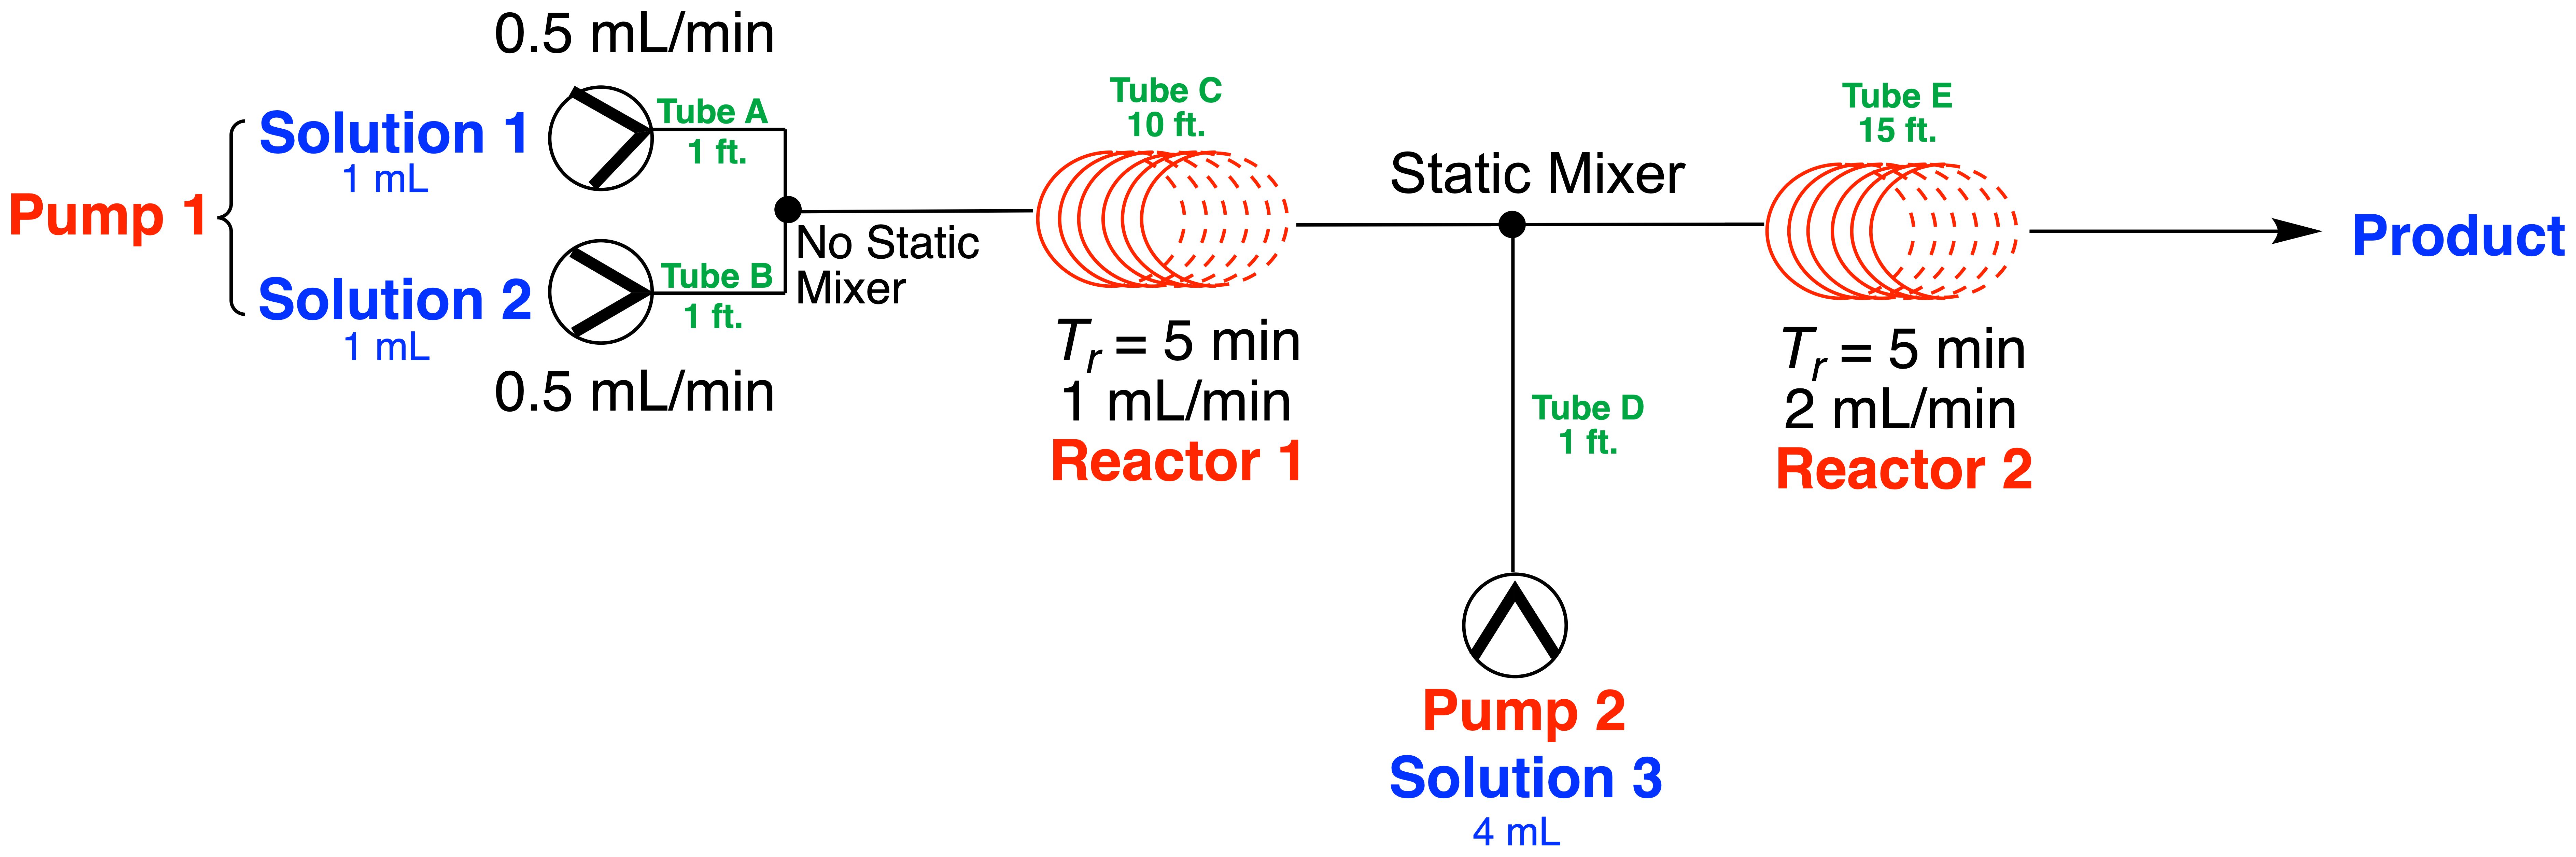

In [ ]:
#On Macs, use the following command in temrinal to find serial port: ls /dev/tty.usb* 
#On Windows, open up Syringe Pump.ipynb and run command in last cell
#Add Varian 
pump_1 = HarvardSyringePump("syringe volume in mL", "syringe diameter in mm", serial_port = 'serial port number')
pump_2 = HarvardSyringePump("syringe volume in mL", "syringe diameter in mm", serial_port = 'serial port number')

### Syringes, Tubing, and Mixers

In [ ]:
#reagent vessels
## name is what will be shown in the diagram
syringe_number = mw.Vessel("name of reagent", name = "name of reagent and solvent")
product_vessel = mw.Vessel("name of product", name = "name of product")

#tubing
#Listed below are 3 of the most common tubing sizes.  
def big_tube(length):
    return mw.Tube(length = length, ID = "0.062 in", OD = "1/8 in", material = "PFA") 
def small_tube(length):
    return mw.Tube(length = length, ID = "0.062 in", OD = "1/8 in", material = "PFA") 
def biggest_tube(length):
    return mw.Tube(length = length, ID = "0.062 in", OD = "1/8 in", material = "PFA") 

tube name = tube_size(length = "length of tube")

#mixers
def Tmixer(name): 
    return mw.TMixer(name = name)
def Ymixer(name):
    return mw.Ymixer(name = name)

mixer_1 = TMixer("name")

#### Example
##### Syringes
```python
syringe_1 = mw.Vessel("Solution 1", name = "Solution 1 in DMF")
```

Repeat for all syringes. 
##### Tubing
```python
tube_A = big_tube(length = "1 foot")
tube_C = big_tube(length = "10 foot")
```

Repeat for all tubing. 
##### Mixers
```python
mixer_1 = TMixer("mixer 1")
```

Repeat for all other mixers. **Even without a static mixer, it is easier to define a T-junction as a T-mixer for writing the apparatus in the next step.**

### Apparatus

In [ ]:
A = mw.Apparatus("name of experiment")

A.add(first_component, second_component, connecting_tubing)

A.visualize() #creates a diagram of the scheme
A.describe() #gives a detailed description of the apparatus (which components are connected by which tubing)

#### Example
```python
A.add(pump_1, syringe_1, tube_A)
A.add(pump_2, syringe_3, tube_D)

A.add(syringe_1, mixer_1, tube_A)
A.add(syringe_2, mixer_1, tube_B)
A.add(mixer_1, mixer_2, tube_C)

A.add(syringe_3, mixer_2, tube_D)
A.add(mixer_2, product_vessel, tube_E)
```

### Protocol

##### Description
The protocol is written in the same stepwise manner that a procedure would be written in. Based on residence times, flow rates, and the volumes of solutions in each syringe, the pumps can be automated to start and stop at the desired times. 

##### Common Variables
- switch - time needed to switch out syringes 
- current - time that pump restarts after switching syringes
- duration - how long the pump runs for

Times can be written in either minutes or seconds. For seconds, change the code to `timedelta(minutes = time)` instead of `timedealta(seconds = time)`. 
##### Procedure
1. Set the switch duration. Switch duration should not be changed throughout the whole experiment. 
2. Set the variable named current to 0. 
3. Set the duration of the pump depending on the volume in the syringes and the flow rate. 
4. To update current time, add the duration of the previous pump. ***If the syringes need to be switched out, add in the switch duration as well.***
5. Repeat Steps 3 and 4 for the rest of the protocol. 

In [ ]:
P = mw.Protocol(A)

# Step 1
switch = timedelta(seconds = switch_duration) 

#Step 2
current = timedelta(seconds = 0)

#Step 3
pump_1_reagents = timedelta(seconds = time)
P.add(pump_1, start = current,
              duration = pump_1_reagents, rate = "pump 1 flow rate")

#Step 4
current += pump_1_reagents + switch

#Step 5
pump_1_flush_initial = timedelta(seconds = time)
P.add(pump_1, start = current,
              duration = pump_1_flush_initial + pump_2_initial, rate = "pump 1 flow rate")

current += pump_1_flush_initial

pump_2_initial = timedelta(seconds = time)
P.add(pump_2, start = current, 
              duration = pump_2_initial, rate = "pump 2 flow rate")

current += pump_2_initial + switch

pump_1_flush_initial = timedelta(seconds = time)
P.add(pump_1, start = current,
              duration = pump_1_flush_initial + pump_2_initial, rate = "pump 1 flow rate")

current += pump_1_flush_initial

pump_2_initial = timedelta(seconds = time)
P.add(pump_2, start = current, 
              duration = pump_2_initial, rate = "pump 2 flow rate")


current += pump_2_initial + switch


flush = timedelta(seconds = time)
P.add(pump_1, start = current
              duration = flush, rate = "pump 1 flow rate")
P.add(pump_2, start = current, 
              duration = flush, rate = "pump 2 flow rate")

current += flush

print(f'TOTAL TIME: {current}')
P.execute(confirm = True)

#### Example
```python
P = mw.Protocol(A)

#Step 1
switch = timedelta(seconds = 30) 

#Step 2
current = timedelta(minutes = 0)

#Step 3
pump_1_reagents = timedelta(minutes = 2)
P.add(pump_1, start = current,
              duration = pump_1_reagents, rate = "0.5 mL/min")

#Step 4
current += pump_1_reagents + switch

#Step 5
pump_1_flush_initial = timedelta(minutes = 10)
P.add(pump_1, start = current,
              duration = pump_1_flush_initial + pump_2_initial, rate = "0.5 mL/min")

current += pump_1_flush_initial

pump_2_initial = timedelta(minutes = 4)
P.add(pump_2, start = current, 
              duration = pump_2_initial, rate = "1 mL/min")


current += pump_2_initial + switch

flush = timedelta(minutes = 20)
P.add(pump_1, start = current
              duration = flush, rate = "0.5 mL/min")
P.add(pump_2, start = current, 
              duration = flush, rate = "1 mL/min")

current += flush

print(f'TOTAL TIME: {current}')
P.execute(confirm = True)
```